# In this notebook, we are going to implement inceptionV3 model to analysis the data
# Applied oversampling for the imbalance data.
## https://arxiv.org/abs/1409.1556


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


In [2]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

In [3]:
#preprocess labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id  dx    dx_type   age     sex     localization  \
7623  HAM_0006666  ISIC_0034268  nv      histo  35.0  female          abdomen   
7600  HAM_0004814  ISIC_0033667  nv      histo  65.0    male  lower extremity   
7184  HAM_0005300  ISIC_0033767  nv      histo  35.0  female  lower extremity   
5568  HAM_0000842  ISIC_0025401  nv  follow_up  45.0    male  lower extremity   
7090  HAM_0005213  ISIC_0033356  nv      histo  30.0  female            chest   

      label  
7623      5  
7600      5  
7184      5  
5568      5  
7090      5  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [4]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

In [5]:
from glob import glob
image_size = 64 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [6]:
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

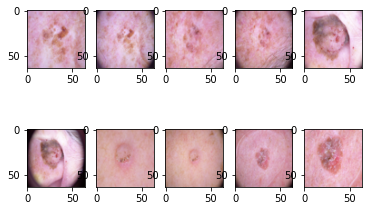

In [7]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

In [22]:
#image to array
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list()).astype("short")
label_to_one_hot = to_categorical(df['label'], num_classes=7)

In [23]:
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.2,random_state=87,stratify=label_to_one_hot)

In [24]:
# apply undersampling instead of class weight
from imblearn.over_sampling import SMOTE
over_sample = SMOTE(random_state=87)
train_data = train_data.reshape(-1,image_size*image_size*3)
train_data_oversample, train_label_oversample = over_sample.fit_resample(train_data, train_label)
train_data_oversample = train_data_oversample.reshape(-1,image_size,image_size,3)

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [25]:
# the sample size is super big so we need to deal with it separately
train_data_oversample = train_data_oversample/255
test_data = test_data/255

In [29]:
#setup InceptionV3 model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
num_classes = 7
dimension = image_size*image_size*3

InceptionV3_model = InceptionV3(input_shape=(image_size,image_size,3), include_top=False,weights='imagenet')
for layer in InceptionV3_model.layers:
    layer.trainable = False

#Flatten layer
temp_layer = Flatten()(InceptionV3_model.output)

#Dense layer 1
temp_layer = Dense(1024,activation='relu')(temp_layer)
temp_layer = Dropout(0.4)(temp_layer)

#output layer
temp_layer = Dense(7,activation='softmax')(temp_layer)

model = Model(InceptionV3_model.input,temp_layer)
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 16, 16, 256)      

AttributeError: module 'keras.utils.generic_utils' has no attribute 'populate_dict_with_module_objects'

In [30]:
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [32]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("InceptionV3.h5", monitor='val_acc', verbose=2, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

In [ ]:
# Train
epochs = 10

train_history = model.fit(
    train_data_oversample,train_label_oversample,
    epochs=epochs,
    steps_per_epoch= 100,
    validation_split=0.2,
    verbose=2,shuffle=True,callbacks=checkpoint)
model.save_weights('InceptionV3_weights.h5')

Epoch 1/10


In [ ]:
# Train + load
model.load_weights('InceptionV3_weights.h5')
epochs = 10

train_history = model.fit(
    train_data_oversample,train_label_oversample,
    epochs=epochs,
    steps_per_epoch= 100,
    validation_split=0.2,
    verbose=2,shuffle=True,callbacks=checkpoint)
model.save_weights('InceptionV3_weights.h5')

In [ ]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

In [ ]:
#plot train history
plot_train_history(train_history,'acc','val_acc')

In [ ]:
# plot loss
plot_train_history(train_history,'loss','val_loss')

In [ ]:
#score
score = model.evaluate(test_data, test_label)
print('Test accuracy:', score[1])

In [ ]:
#predictions

prediction = model.predict(test_data)

prediction_class = np.argmax(prediction,axis=1)
print(prediction_class)
prediction_label = np.argmax(test_label,axis=1)

#confusion matrix
print(pd.crosstab(prediction_label,prediction_class,rownames=['label'],colnames=['predict']))
mapping = lambda x:features_dict[x]
pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
#pred_label_to_feature = prediction_label.map(lambda x:features_dict[x])

#confusion matrix
print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,rownames=['actual'],colnames=['predicted']))
